# Long Short Trading Strategy backtest
The following notebook implements backtest of the trading strategy based on the idea that the instruments that strongly outperforms the market tend to go down in the nearest future and vice versa. More detailed description of the strategy can be found in docstring for LongShortTradingStrategy.py


Following steps are performed in the research:
   1. Prepare the data
   2. Optimize strtegy parameters on the training dataset
   3. Run the optimal strategy on test data

In [1]:
from LongShortTradingStrategy import LongShortTradingStrategy
from tools import *
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

### 1. Load and prepare the data
We use daily time bars for the Binance spot market during the period of 2020-01-01 - 2022-01-01. Then we extract close prices from the time bars.

In [4]:
bars_data = load_ohlc_data('data/binance_1d')
prices_data = get_bar_value_for_all_tickers(bars_data, 'close')
prices_data.head()

,1INCHUSDT,AAVEUSDT,ACMUSDT,ADAUSDT,ADXUSDT,AGLDUSDT,AIONUSDT,AKROUSDT,ALCXUSDT,ALGOUSDT,...,XTZUSDT,XVGUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,0.03348,NaN,NaN,NaN,NaN,NaN,0.2201,...,1.3700,NaN,NaN,NaN,NaN,NaN,28.07,NaN,NaN,0.1825
2020-01-02,NaN,NaN,NaN,0.03269,NaN,NaN,NaN,NaN,NaN,0.2139,...,1.2428,NaN,NaN,NaN,NaN,NaN,27.02,NaN,NaN,0.1752
2020-01-03,NaN,NaN,NaN,0.03417,NaN,NaN,NaN,NaN,NaN,0.2272,...,1.2785,NaN,NaN,NaN,NaN,NaN,28.41,NaN,NaN,0.1821
2020-01-04,NaN,NaN,NaN,0.03434,NaN,NaN,NaN,NaN,NaN,0.2352,...,1.2557,NaN,NaN,NaN,NaN,NaN,29.91,NaN,NaN,0.1864
2020-01-05,NaN,NaN,NaN,0.03460,NaN,NaN,NaN,NaN,NaN,0.2294,...,1.2545,NaN,NaN,NaN,NaN,NaN,30.81,NaN,NaN,0.1861


##### Split into data into training and testing samples

In [6]:
train_prices_data, test_prices_data = train_test_split(prices_data, test_size=0.3, train_size=0.7, shuffle=False)

### 2. Strategy parameters optimization
First, we optimize strategy parameters using the optuna library (https://optuna.org). We don't validate the strategy configuration and let the optimizer work with limits for maximum consequtive time periods is profit/loss.

In [15]:
train_strategy1, best_params1 = optimize_strategy_params(train_prices_data,
                                                         up_q_bounds=(0.01, 0.1), down_q_bounds=(0.01, 0.1),
                                                         max_profit_bounds=(0.001, 0.1), max_loss_bounds=(0.001, 0.1),
                                                         max_t_in_pos_bounds=(1, 50),
                                                         optimize_max_t_in_profit_and_loss=True,
                                                         n_trials=20)

[I 2022-05-10 17:22:32,328] A new study created in memory with name: no-name-6993cf95-a803-4156-ac03-6ccf41909391
[I 2022-05-10 17:22:35,659] Trial 0 finished with value: 1.2034017562619603 and parameters: {'up_q': 0.04370861069626263, 'down_q': 0.09556428757689246, 'max_profit': 0.07346740023932911, 'max_loss': 0.06026718993550663, 'max_t_in_pos': 8, 'max_t_in_profit': 2, 'max_t_in_loss': 1}. Best is trial 0 with value: 1.2034017562619603.
[I 2022-05-10 17:22:38,974] Trial 1 finished with value: -0.1466859230048775 and parameters: {'up_q': 0.08795585311974417, 'down_q': 0.0641003510568888, 'max_profit': 0.07109918520180851, 'max_loss': 0.0030378649352844423, 'max_t_in_pos': 49, 'max_t_in_profit': 41, 'max_t_in_loss': 11}. Best is trial 0 with value: 1.2034017562619603.
[I 2022-05-10 17:22:41,686] Trial 2 finished with value: -0.2467185413477217 and parameters: {'up_q': 0.02636424704863906, 'down_q': 0.026506405886809047, 'max_profit': 0.03111998205299424, 'max_loss': 0.052950886731591

In-sample results don't look very promising: strategy doesn't overplays benchmark and has very high correlation with it. It can be explained by the fact that the optimal value of 'up_q' is 0.03 and optimal 'down_q' is 0.066 - it means that the strategy goes long twice as much as it goes short.

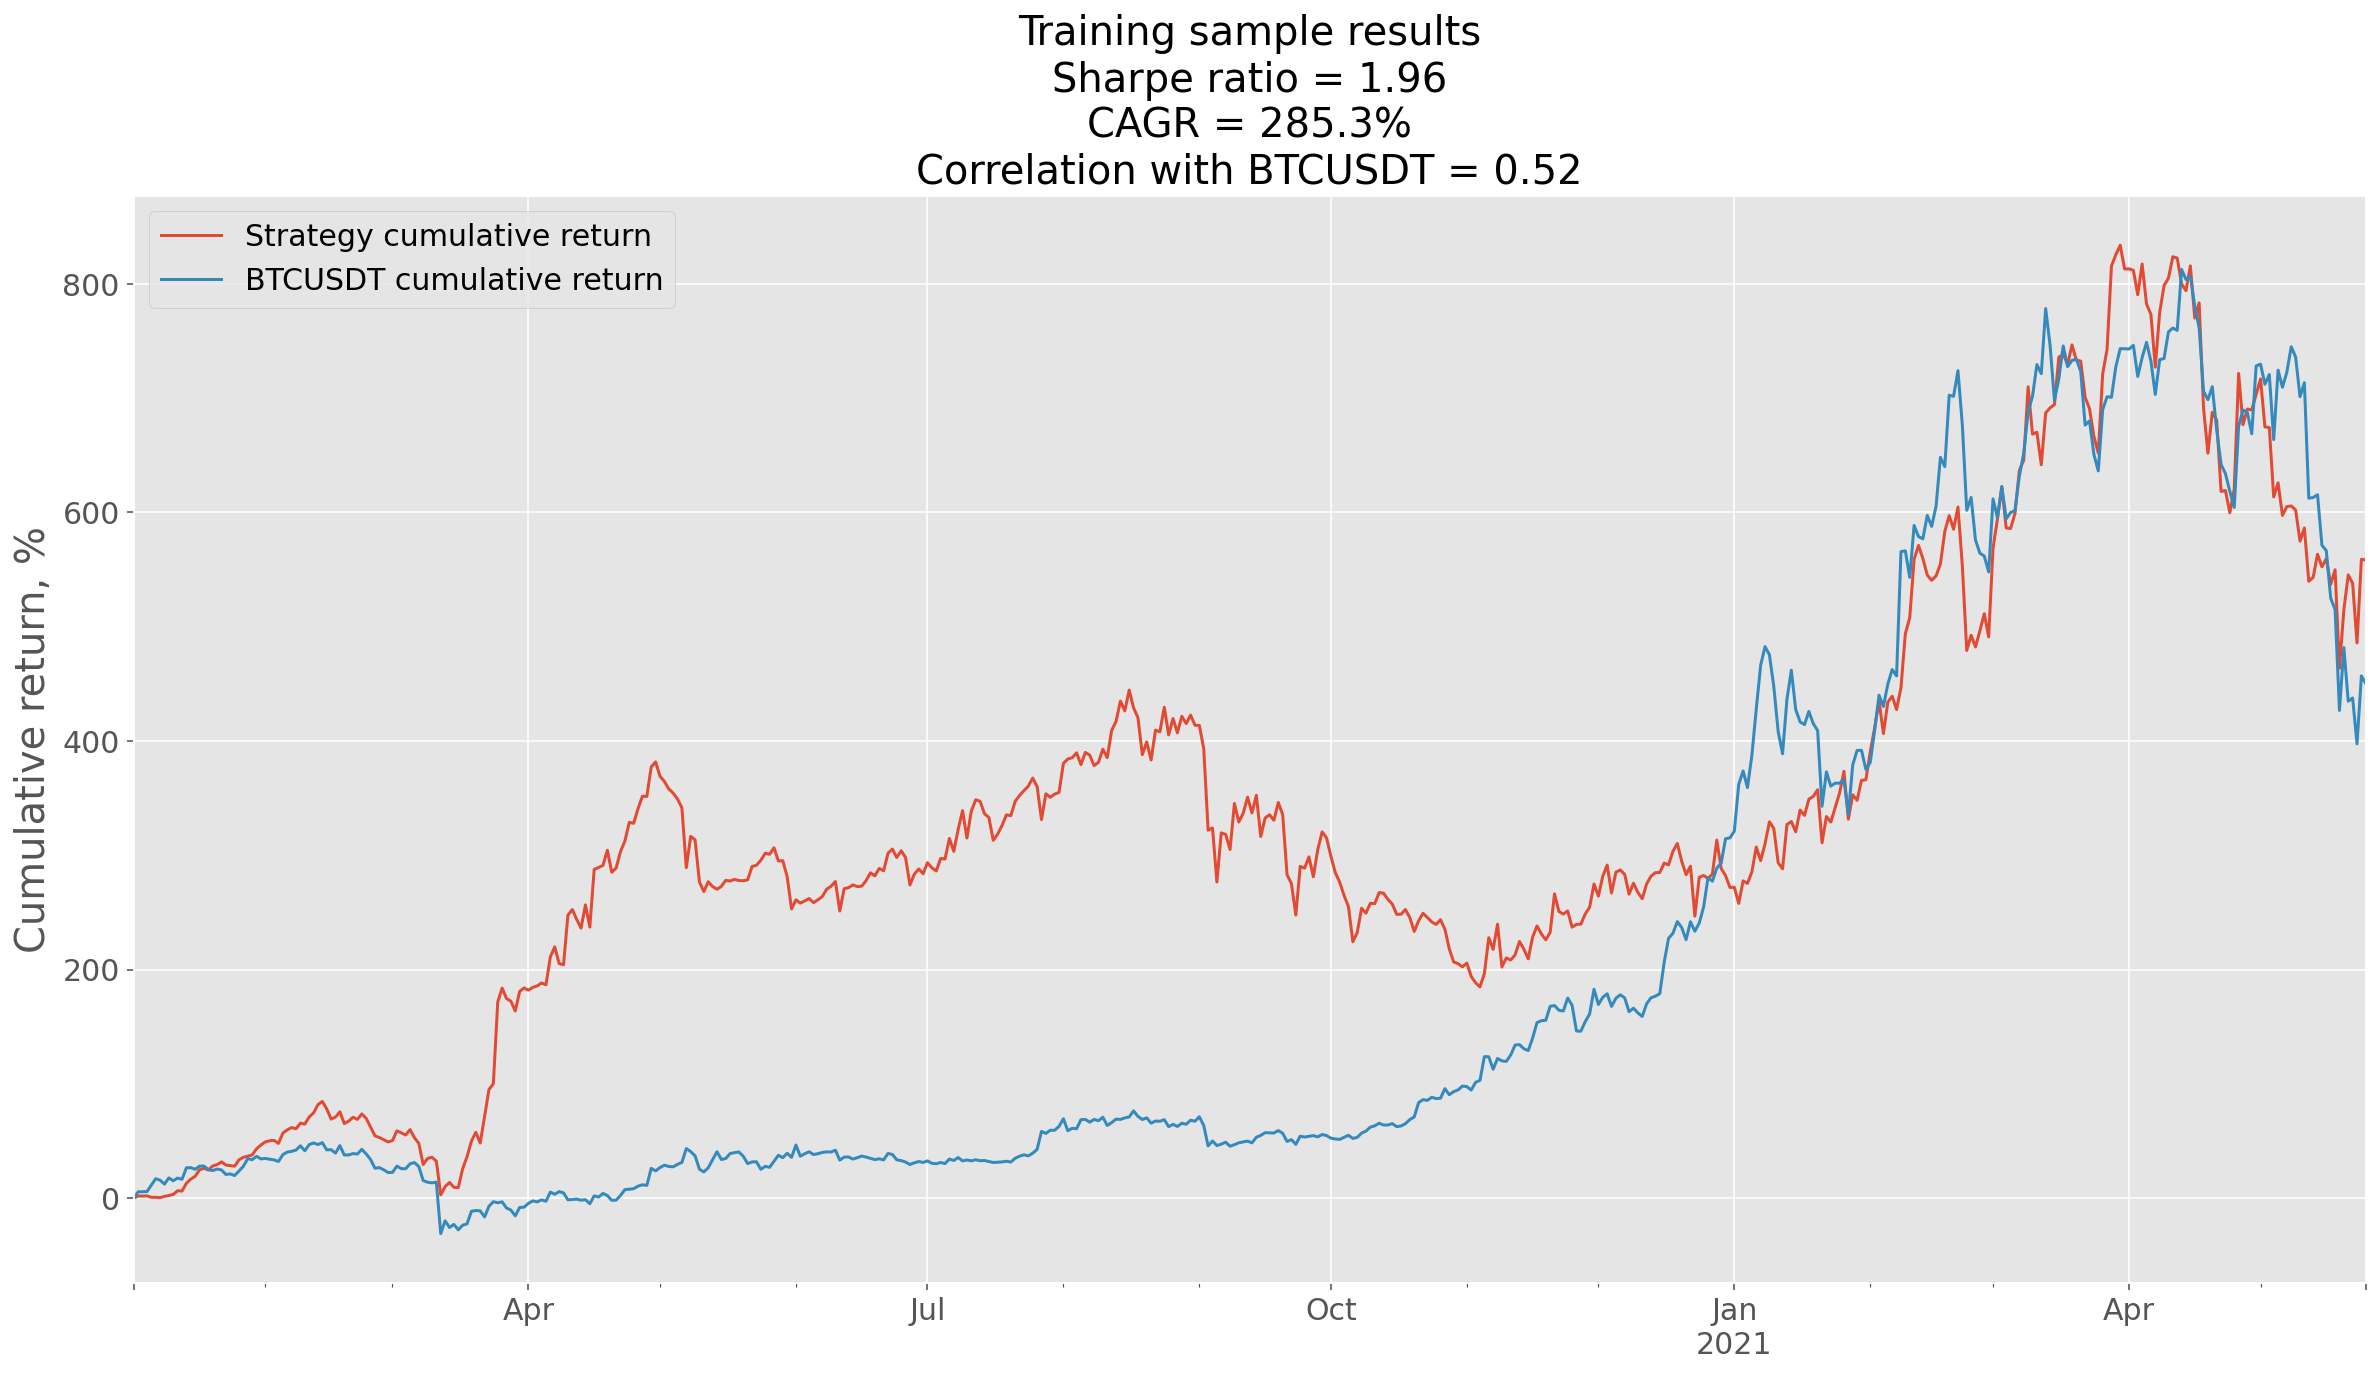

In [16]:
plot_strategy_results(train_strategy1, 'Training sample results')

High correlation to the market played its role: out-of-sample is the period when the benchmark showed pure p&l. As a result, the strategy worked almost the same.

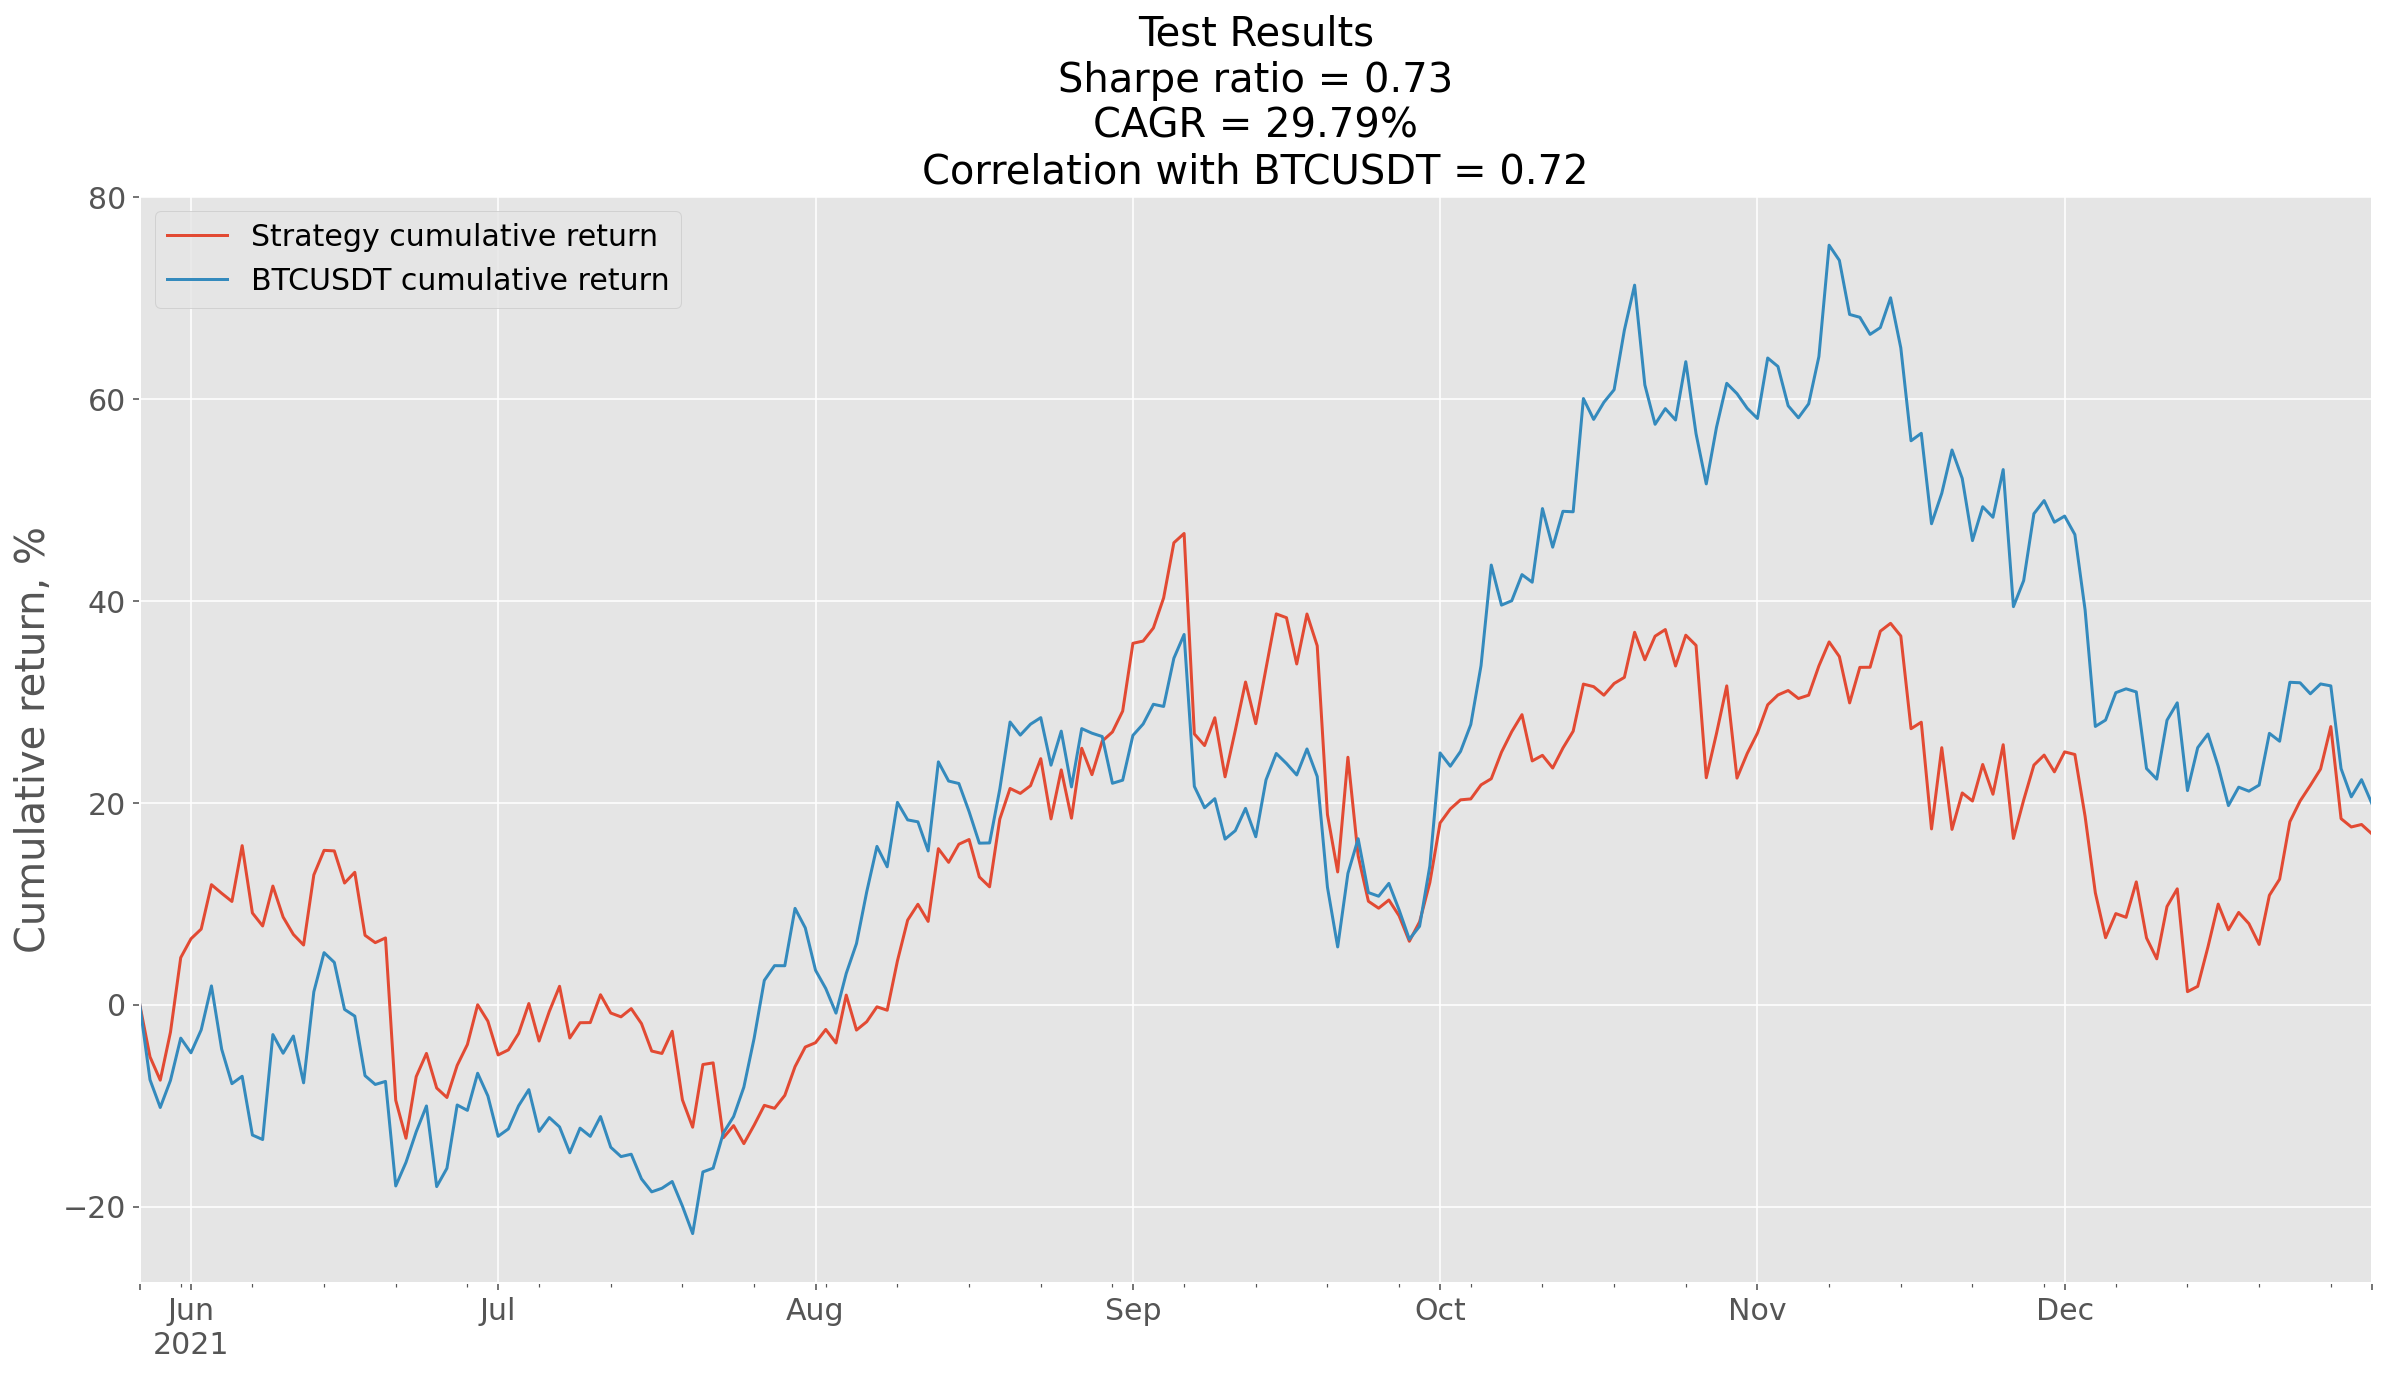

In [17]:
test_strategy = LongShortTradingStrategy(test_prices_data, benchmark_ticker='BTCUSDT')
test_strategy.set_strategy_params(**best_params1)
test_strategy.run()
plot_strategy_results(test_strategy, 'Test Results')